<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/ResamplingApproaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resampling Approaches

Resampling methods are applied to get better estimates of the model by repeatedly drawing samples from population data (training set) and refitting the model. 

### Types of resampling methods

- Validation set or hold-out validation (Baseline)
- Leave one out cross-validation
- K-fold cross-validation
- Bootstrap method.

In the following sections we understand each method and at the end of this notebook we will learn how to choose a method based on the situation.


In [103]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneOut
import time


%matplotlib inline
warnings.filterwarnings('ignore')

In this notebook we will use open dataset called advertising data set. The data contains the amount of investment made towards 'TV, Radio, Newspaper' advertisement that resulted in increase in 'Sales' of a product. The investment amoun is in $1000s of dollars, and Sales shows the increase in the units. 

In [104]:
df = pd.read_csv("https://raw.githubusercontent.com/sriksmachi/sriksml/main/data/Advertising.csv", index_col=0)
df.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


<Figure size 432x288 with 0 Axes>

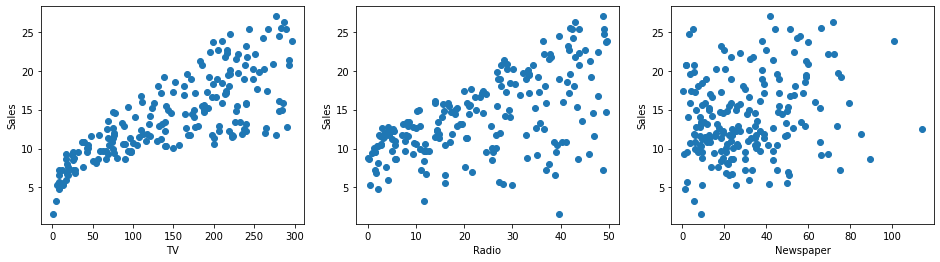

Figure displaying the relationship between Sales and Budget invested in TV, Radio, Newspaper


In [105]:
fig = plt.figure()
fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].scatter(x=df['TV'], y=df['Sales'])
ax[0].set_ylabel("Sales")
ax[0].set_xlabel('TV')
ax[1].scatter(x=df['Radio'], y=df['Sales'])
ax[1].set_ylabel("Sales")
ax[1].set_xlabel('Radio')
ax[2].scatter(x=df['Newspaper'], y=df['Sales'])
ax[2].set_ylabel("Sales")
ax[2].set_xlabel('Newspaper')
plt.show()
print('Figure displaying the relationship between Sales and Budget invested in TV, Radio, Newspaper')


From the graphs above we can notice that the relationship is almost Linear, hence we will use simple linear regression model (least squares) to estimate the coefficients.

Often a model works well on training data, more flexible the model becomes lower the bias of the model. However, the model exhibits high variance and high test error as the flexibility increases. Hence, test error plays a vital role in indentifying the fitness of the model. For this example, we will use the Mean Squared Error & R-square (R2) as the quality metric to identify how the well the model is performing.

In [106]:
# Calculating the MSE and R2 using all the training data.

y = df['Sales']
X = df[['TV', 'Radio', 'Newspaper']]
lm = LinearRegression()
lm.fit(X, y)
y_preds = lm.predict(X)
residuals = (y_preds - y)
print(f'RMSE: {mean_squared_error(y, y_preds)}')
print(f'R2: {r2_score(y, y_preds)}')


RMSE: 2.784126314510936
R2: 0.8972106381789522


## Validation Set Approach

In Validation set approach we randomly divide the training data into training set and validation set also called hold-out set. The model is trained on the training set and validation set is used to calculate the test error. It is simplest of the methods and often acts as baseline while evaluating different resampling approaches. 

In [107]:
from sklearn.model_selection import train_test_split
y = df['Sales']
X = df[['TV', 'Radio', 'Newspaper']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7, random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 170 to 103
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         140 non-null    float64
 1   Radio      140 non-null    float64
 2   Newspaper  140 non-null    float64
dtypes: float64(3)
memory usage: 4.4 KB


In [108]:
now = time.time()
lm = LinearRegression()
lm.fit(X_train, y_train)
y_test_preds = lm.predict(X_test)
y_train_preds = lm.predict(X_train)

def summary(y_train, y_test, y_train_preds, y_test_preds):
  residuals = (y_test_preds - y_test)
  print(f'Train MSE: {mean_squared_error(y_train, y_train_preds)}')
  print(f'Train R2: {r2_score(y_train, y_train_preds)}')
  print(f'Test MSE: {mean_squared_error(y_test, y_test_preds)}')
  print(f'Test R2: {r2_score(y_test, y_test_preds)}') 

summary(y_train, np.array(y_test), y_train_preds, y_test_preds)
print(f"Time taken: {time.time() - now}ms")
print(f"Coefficient Estimates : {lm.coef_}")

Train MSE: 2.4793551789057866
Train R2: 0.9055159502227753
Test MSE: 3.79679723671522
Test R2: 0.8609466508230368
Time taken: 0.011326313018798828ms
Coefficient Estimates : [0.04405928 0.1992875  0.00688245]


Validation set approach has the following disadvantages.
- Statistical models like LS fit perform well when the sample size is large. Since we are using only 70% of the data, the coefficient estimates are sub-optimal. This difference can be noticed in slight increase in Train MSE and decrease in Train R2 compared to the above.
- The models is as good as the samples included in the training set, since the split is random if the training set contains the good samples the model performs well. 
- Due to the randomness in generating the training set and validation set, the results are not always the same. 

# Leave one out cross-validation

LOOCV addresses the problems from the validation dataset. For a training set with **n** observations, LOOCV proposes to fit the model **n** times, with each time leaving exactly one observation out. The left out observation is then used to calculate the test error. The final test error is then calculated as mean of test errors from each iteration.



In [109]:
now = time.time()
loo = LeaveOneOut()
y = df['Sales']
X = df[['TV', 'Radio', 'Newspaper']]
lm = LinearRegression()
mse = []
i = 0
for train_index, test_index in loo.split(X):
  i+=1
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  lm.fit(X_train, y_train)
  y_train_preds = lm.predict(X_train)
  y_test_preds = lm.predict(X_test)
  mse.append(mean_squared_error(np.array(y_test), y_test_preds))
  
print(f"Test MSE : {np.sum(mse)/len(mse)}")
print(f"Time taken: {time.time() - now}ms for {i} splits")
print(f"Coefficient Estimates : {lm.coef_}")

Test MSE : 2.946899800569503
Time taken: 0.9468033313751221ms for 200 splits
Coefficient Estimates : [ 0.04587856  0.18806189 -0.00136808]


Using LOOCV, the test MSE is reduced (low bias) since the model now has more observations to use. Secondly, since all the data samples are used for validation and an average of the MSE is taken, the results when LOOOCV is used is always constant. However, the time taken to fit the model increased, this is due to increase in number of iterations. For training a larger dataset, the 

# K-Fold Cross Validation

K-Fold cross validation is very similar to LOOCV except that instead of leaving one sample out we divide the data samples into K folds (or groups). The model is trained on K-1 folds and the remaining hold-out set is used to calculate the Test MSE. The training is repeated K times by shuffling the hold-out set. Final Test MSE is calculated as a mean of Test MSE for K iterations. 

In [110]:
from sklearn.model_selection import KFold
now = time.time()
kf = KFold(n_splits=5)
lm = LinearRegression()
i=0
# kf.split returns a list of train and test indexes
for train_index, test_index in kf.split(X):
  i+=1
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  lm.fit(X_train, y_train)
  y_test_preds = lm.predict(X_test)
  mse.append(mean_squared_error(np.array(y_test), y_test_preds))

print(f"Test MSE : {np.sum(mse)/len(mse)}")
print(f"Time taken: {time.time() - now}ms for {i} splits")
print(f"Coefficient Estiates: {lm.coef_}")

Test MSE : 2.949974112680008
Time taken: 0.026343107223510742ms for 5 splits
Coefficient Estiates: [ 0.0472521   0.179922   -0.00094408]


This model performs almost same as LOOCV with a considerable reduction in the time taken. However given the randomness of the split, the result always varies slightly.

# Bootstrap

Using bootstrap we can identify the standard error associated with estimating the coefficients of the model. In bootstrap sampling we continuously sample from population data with repeatition. Unlike remaining methods, here we do not calculate test MSE because the data is sampled at random with repetitions. 
If the data contains outliers, this approach may lead to incorrect estimates of the coefficients due to multiple repetitions of the outlier in the training dataset.

In [115]:
iterations = 200 
n_points = 100
i = 0
coeff = []
tv, radio, newsp = 0, 0, 0
now = time.time()
for _ in range(iterations):
  i+=1
  sample_df = df.sample(n=n_points, replace=True)
  y = sample_df['Sales']
  X = sample_df[['TV', 'Radio', 'Newspaper']]
  lm.fit(X, y)
  tv += lm.coef_[0]
  radio += lm.coef_[1]
  newsp += lm.coef_[2]
print(f"Time taken: {time.time() - now}ms for {i} splits")
print(f"Coefficient Estiates: {tv/iterations, radio/iterations, newsp/iterations}")

Time taken: 0.49674558639526367ms for 200 splits
Coefficient Estiates: (0.04552252689553685, 0.18981118124308835, -0.0003038928239470163)


# Summary

The table below summarizes the concepts explained in this notebook. 
For any given predictive modeling problem, all of these approaches can be applied. Validation set approach being the simplest can always act as baseline on which other methods can be evaluated.  

||Test MSE|Bias|Variance|Time Taken|When to use
|-|-|-|-|-|-|
|Validation set|3.796|High|High|0.0113| Baseline
|LOOCV|2.946|Low|Highest|0.9468| Reduce bias,Smaller datasets, computationally inexpensive.
|K-Fold|2.949|Intermediate (little higher than LOOCV)|Low|0.0263|Larger dataset, reduce variance.

Bootstrap though only an estimation technique, it can still be used in estimating the standard error in case of regression models where coefficients are estimated. 
